## Based on CRTS_sel_g_cut_vs_r_cut.ipynb,   taking only the code needed to make Fig. 2 

A testbed for making Fig.2 :  the 4-panel plot.  The 4-panel plot shows the problem :  how we can't get anything meaningful if we plot various characteristics of uncorrected data. Thus there is no reason to do splitting into magnitude bins, correcting, etc - it's not the purpose here. 

The desired magnitude range for the paper is 18.5-19 

In [23]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

import CRTS_paper_modules as mod
import imp
imp.reload(mod)
#reload(mod)

<module 'CRTS_paper_modules' from '/Users/chris/GradResearch/CRTS_PROJECT/code/CRTS_paper_modules.py'>

In [24]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_catalogs/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


In [25]:
Min = 18.5
Max = 19

objects_in_cut = {}

mag = 'r'
cut_mag = mag
report_mag = mag

print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
print('\n Reporting SDSS %s  '% report_mag)

good_ids_S_blue = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                          gi_Max=1, cut_mag=cut_mag + '_mMed')

good_ids_S_red = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
                                       gi_Max=3, cut_mag=cut_mag + '_mMed' )

good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                           cut_mag=cut_mag)
#objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'starsR':good_ids_S_red, 
#                       'qso':good_ids_QSO}



Using now only lightcurves with SDSS  18.500000< r < 19.000000

 Reporting SDSS r  

Choosing stars with  SDSS   -1.00<g-i<1.00
 These cuts reduced the number of stars  in the sample from 48250 to 1496

Choosing stars with  SDSS   1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 2327

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 747


## Read the xi, ei for objects in the r_cut ... 

In [26]:
mod.faster_read_xi_ei?

In [ ]:
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

# read the simple way , no need to do the generic read ... 
out_dic['qso'] = mod.faster_read_xi_ei(inDirSF = inDirQSO,good_ids = good_ids_QSO )
out_dic['starsB'] = mod.faster_read_xi_ei(inDirSF = inDirStars,good_ids = good_ids_S_blue )
out_dic['starsR'] = mod.faster_read_xi_ei(inDirSF = inDirStars,good_ids = good_ids_S_red )



Reading in tau,xi,ei  for 747 objects
[######### ] 99.73%
Finished reading all master files for the selected objects ...

Reading in tau,xi,ei  for 1496 objects
[########  ] 80.55%

## Plot the raw data ... 

In [359]:
import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'
%matplotlib inline
obj = 'starsB' # qso' #  # QSO 
m_ij = out_dic[obj][0]
tau =  out_dic[obj][1]
e_ij = out_dic[obj][2]


rms_std = lambda x : np.std(x)
stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                      bins=nbins)
bin_stdev = stdev_binned[0][non_empty_bins]

# some m_ij seems completely unphysical... seems that there may be some 'outlier' points in lightcurves 
# that are completely off the scale, and maybe should be discarded at earlier  stage ... 

# makes sense that if there is one outlier point, then all magnitude differences calculated from 
# that point will be offset as much as that point 

m=abs(m_ij)<2

xdata = np.log10(tau[m])
ydata =  m_ij[m]
H, xedges, yedges = np.histogram2d(xdata,ydata, bins=70)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor

fig,ax = plt.subplots(1,1,figsize=(12,4))
image  = ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)
colorbar = plt.colorbar(image)
colorbar.set_label(r'$\log_{10}{\mathrm{(count)}}$', fontsize=20)


min_x , max_x, step_size = 0, 3.5 , 0.1

mean_x = np.arange(min_x, max_x , step_size)
median_y = np.zeros(len(mean_x)-1)
rms_y = np.zeros(len(mean_x)-1)

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  (mean_x[j]< xdata[mask_xy] )*(xdata[msk_xy]<  mean_x[j+1])
    median_y[j] = np.median(ydata[mask_xy][mask])
    rms_y[j] = np.sqrt(np.mean(np.power(ydata[mask_xy][mask], 2.0 )))

# Overplot the median y quantity,  and median +/-  rms 
ax.scatter(mean_mag[:-1], median_y, c = 'magenta', s=50)
ax.scatter(mean_mag[:-1], median_y+rms_y, c = 'orange', s=50)
ax.scatter(mean_mag[:-1], median_y-rms_y, c = 'orange', s=50)




ax.set_xlabel(r'$\log_{10}(\tau)$', fontsize=15)
ax.set_ylabel(r'$\Delta m_{ij}$',fontsize=15)
ax.set_title('CRTS '+obj)
plt.tight_layout()
plt.savefig(outDir+'Fig_2_raw_data_'+obj+'_'+str(Min)+'-'+str(Max)+'.png')

KeyError: 'starsB'

## Calculate SF, mu in approximate and  full  ways

In [339]:
# for all imports of my functions, 
# make python aware of my packages...
import sys
sys.path.insert(0, '../../SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF


In [8]:
os.getcwd()[:-4]

'/Users/chris/GradResearch/CRTS_PROJECT/'

In [7]:
# Run the calculation over all bins : 
# - keep the option to plot a bin if one wants to compare the three methods : need to provide object N
#   
# - as it is, calculate three values for sigma, etc., and plot it  

# Set the bin  : here we use only r_cut 
b = 'r_cut'

# set the bin number 
nbins = 200 

# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_2_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in out_dic[b].keys():
    print('\n For obj = %s'% obj)
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[b][obj][0]
    tau =  out_dic[b][obj][1]
    e_ij = out_dic[b][obj][2]

    #n =  out_dic[b][obj][3]

    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    #bin_names = np.arange(1,len(binned_count[2]))

     # Calculate median preprocessed photometric error per bin 
    binned_err_median = binned_statistic(tau, e_ij, statistic='median', bins=nbins) 
    err_median = binned_err_median[0]

    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 

    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]
    err_median = err_median[non_empty_bins]

    # Which point belongs to which bin
    bin_number  = binned_tau[2]
    
    ####
    ####  Panel 1 : Standard Deviation 
    ####

    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)
    bin_stdev = stdev_binned[0][non_empty_bins]  
    #bin_number = stdev_binned[2]  
     # since each point belongs to some bin : len(bin_number) =len(delflx)


    # error on standard deviation in the bin     
    # calculate when plotting, since it's just a function of bin count... 
    
    #err_stdev = bin_stdev / np.sqrt(2.0*(bin_count - 1.0))

    #####
    ##### Panel 2  : Gaussian rms  
    #####
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    #####
    ##### Panel 3 (SF)   and Panel 4   (mu)
    #####


    # Loop over all bins  calculating approximate mu and sigma 

    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ei = e_ij[bin_number == N]
        print('N_points = %d'%len(xi))
   
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 


    # Save the results of calculation  : Panel 1,2,3,4 

    fname = outDir+ b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    
    data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount'
    np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print('Results saved as %s' % fname)

print('Done with calculating panel data ')

Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-03-24/

 For obj = starsB
 --- Calculating mu, sigma for bin 1
N_points = 70728
 --- Calculating mu, sigma for bin 2
N_points = 84759
 --- Calculating mu, sigma for bin 3
N_points = 62715
 --- Calculating mu, sigma for bin 4
N_points = 60328
 --- Calculating mu, sigma for bin 5
N_points = 41466
 --- Calculating mu, sigma for bin 6
N_points = 46231
 --- Calculating mu, sigma for bin 7
N_points = 33179
 --- Calculating mu, sigma for bin 8
N_points = 40338
 --- Calculating mu, sigma for bin 9
N_points = 28209
 --- Calculating mu, sigma for bin 10
N_points = 38625
 --- Calculating mu, sigma for bin 11
N_points = 27895
 --- Calculating mu, sigma for bin 12
N_points = 33678
 --- Calculating mu, sigma for bin 13
N_points = 30269
 --- Calculating mu, sigma for bin 14
N_points = 33825
 --- Calculating mu, sigma for bin 15
N_points = 28519
 --- Calculating mu, sigma for bin 16
N_points = 36

Plot below the raw $\Delta m_{ij}$ for quasars, applying my mask. 

In [66]:
import colorcet as cc
#cc.colorwheel

KeyError: 'r_cut'

## Read in the calculation results 

If the calculation for each bin has already been done, and only some fine tuning is needed for the figure, you can set the Min, Max mags for the cut below, and we will read in the results from the files and plot it all. 

In [3]:
import numpy as np 

from collections import OrderedDict
plot_data = OrderedDict()


Min = 18.5
Max = 19


outDir = '../data_products/Fig_2_data/2017-03-24/'
for obj in ['qso', 'starsB', 'starsR']:
    plot_data[obj] = {}

    fname = outDir+ 'r_cut_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    print('Reading from %s'%fname)

    colnames = open(fname,'r').read().splitlines()[0][1:].split()
    d = np.genfromtxt(fname, dtype=float)

    for label, column in zip(colnames, d.T):
        plot_data[obj][label] = column


Reading from ../data_products/Fig_2_data/2017-03-24/r_cut_18.5-19_qso.txt
Reading from ../data_products/Fig_2_data/2017-03-24/r_cut_18.5-19_starsB.txt
Reading from ../data_products/Fig_2_data/2017-03-24/r_cut_18.5-19_starsR.txt


## Make Fig.2 : four-panel plot (can run only cells below to make  Fig.2) 

Note: now since we are convinced that the full results are better than the approximate ones, we plot only muFull and sigmaFull. But muApprox and sigmaApprox is still there... 

In [4]:
import matplotlib 
from matplotlib import rcParams
#matplotlib.rcParams['font.size'] = 17

#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

Figure is saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-03-24/Fig_2_18.5-19_panels.png


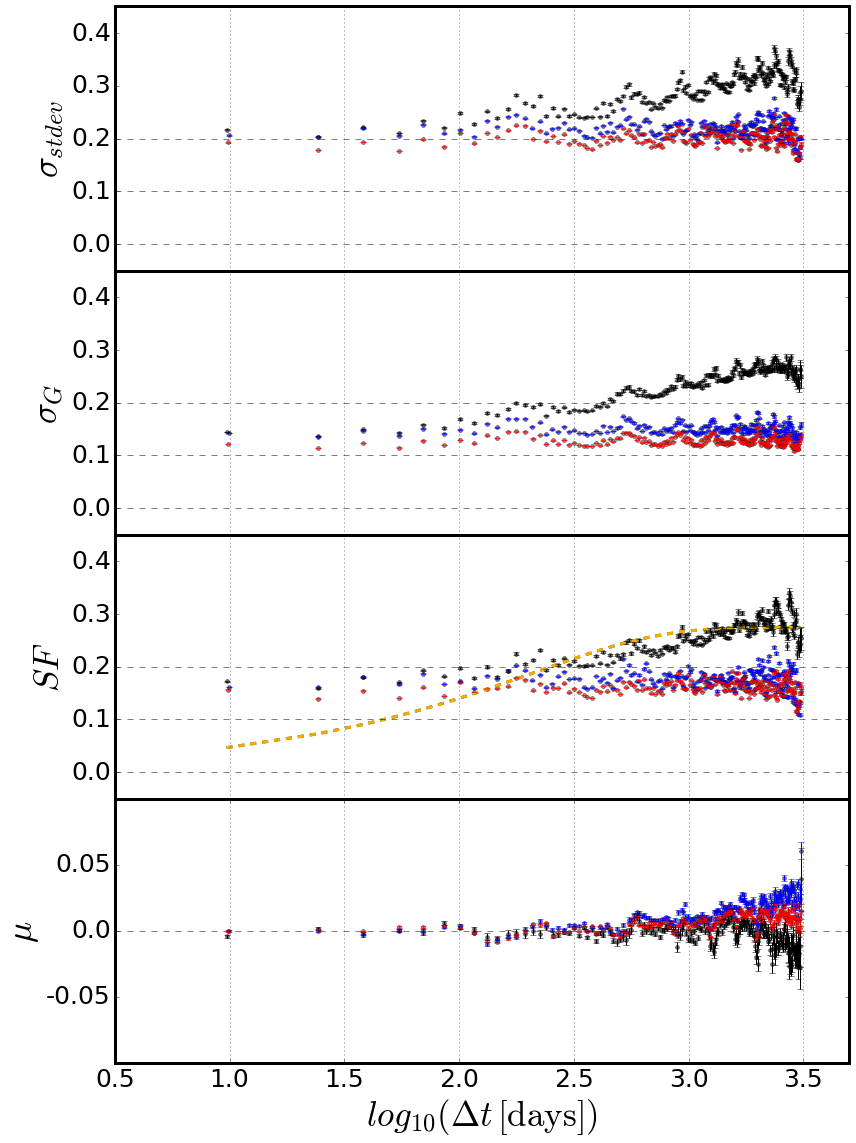

In [35]:
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,ax = plt.subplots(4,1, figsize=(12,16), sharex=True)


# Panel 1 
for obj in plot_data.keys() : 
    ax[0].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax[0].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax[0].set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
ax[0].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[0].set_ylim(bottom=y_bott, top=y_top)
ax[0].set_xlim(left=x_left, right=x_right)
ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[0].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].grid(axis='x')



# Panel 2
for obj in plot_data.keys() : 
    ax[1].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaG'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errSigmaG = plot_data[obj]['sigmaG']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    ax[1].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaG'],errSigmaG, 
                   linestyle='None', c = colors[obj] )


ax[1].set_ylabel(r'$\sigma_{G}$')   # ,fontsize=20 
ax[1].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[1].set_ylim(bottom=y_bott, top=y_top)
ax[1].set_xlim(left=x_left, right=x_right)
ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[1].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].grid(axis='x')




    # mu_bins['approx_err'] = bin_stdev / np.sqrt(bin_count)


# Panel 3
 
def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf

# Calculate the model DRW fit for QSO
obj = 'qso'
xdata = plot_data[obj]['meanTau']
sf = plot_data[obj]['sigmaFull']
popt, pcov = curve_fit(model_sf, xdata, sf)
y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 

# Fold-in the error to the model SF , plot 
# both folded and not-folded version 

err_sig = plot_data[obj]['sigmaFull']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
y_fold = np.sqrt((y ** 2.0)+ (err_sig ** 2.0) )
ax[2].plot(np.log10(xdata), y_fold , lw=3, c = 'green', ls='--')
ax[2].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')

#text = r'$ \mathrm{Model:}\ \tau=%.3f \,\mathrm{days} , \ SF_{\infty}=%.3f \,\mathrm{mag}$'%(popt[1],popt[0])
#ax[2].text(x=0.75, y=0.3,s = text )


# plot approximate sigma 
for obj in plot_data.keys() : 
    
    ax[2].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaFull'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    err_sig = plot_data[obj]['sigmaFull']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    # 
    ax[2].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaFull'],err_sig, 
                   linestyle='None', c = colors[obj]  )
    
    
ax[2].set_ylim(bottom=y_bott, top=y_top)
ax[2].set_xlim(left=x_left, right=x_right)
ax[2].set_ylabel(r'$SF $') # ,fontsize=20  
ax[2].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off')
ax[2].grid(axis='x')
ax[2].set_yticks([0,0.1,0.2,0.3,0.4])
ax[2].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[2].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)    
ax[2].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[2].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al) 

# Panel 4 
for obj in plot_data.keys() : 
    ax[3].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['muFull'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    err_mu =  plot_data[obj]['stdev'] / np.sqrt(plot_data[obj]['binCount'])
    ax[3].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['muFull'],err_mu, 
                   linestyle='None', c = colors[obj]  )
    
ax[3].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[3].set_ylim(top=y_mu_top, bottom=y_mu_bott)
ax[3].set_xlim(left=x_left, right=x_right)
ax[3].set_yticks([-0.05,0,0.05])
ax[3].set_yticklabels(['-0.05','0.0', '0.05'])  
ax[3].set_ylabel(r'$\mu$') # , fontsize=20 
ax[3].grid(axis='x')
ax[3].set_xlabel(r'$log_{10} (\Delta t \, \mathrm{[days]} )$') # ,fontsize=20

figname = outDir+'Fig_2_'+str(Min)+'-'+str(Max)+'_panels.png'
plt.tight_layout()
fig.subplots_adjust(hspace=0)

plt.savefig(figname)
print('Figure is saved as %s'% figname )

# 

#Show that indeed full vs approximate are slightly different, but not too much..
plt.scatter(plot_data['qso']['sigmaFull'], plot_data['qso']['sigmaApprox'])
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='black')

In [5]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)



Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-18/


In [65]:
plot_data

OrderedDict([('qso',
              {'binCount': array([ 36354.,  46439.,  34110.,  33773.,  22990.,  24468.,  15028.,
                       16514.,   9150.,  10843.,   7129.,   8361.,   7680.,   9283.,
                        8724.,  14182.,  13565.,  20330.,  21397.,  27191.,  31740.,
                       36587.,  44969.,  37994.,  42319.,  30322.,  30392.,  22071.,
                       21149.,  15000.,  16209.,  10923.,   9673.,   6884.,   7525.,
                        6213.,   7577.,   6943.,  10218.,   9622.,  14803.,  15814.,
                       21791.,  21909.,  31162.,  33414.,  35706.,  36522.,  31061.,
                       30025.,  22020.,  23097.,  14401.,  16442.,   9776.,  11374.,
                        6213.,   6572.,   5643.,   5918.,   5006.,   7945.,   7061.,
                       12082.,  11853.,  16163.,  19478.,  21625.,  26628.,  26208.,
                       34289.,  26848.,  30329.,  20447.,  22122.,  14597.,  16353.,
                       10755.,  

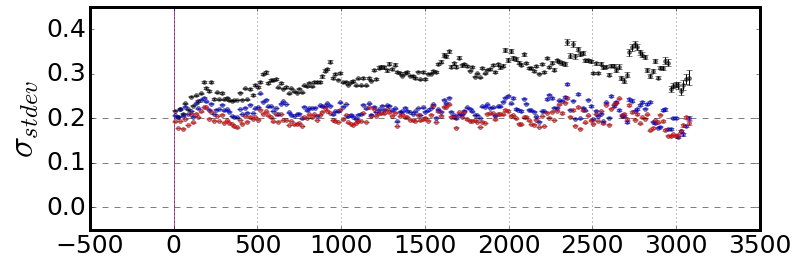

In [8]:
### Take data from the peak and the minimum around 1000 days  (log(t) = 3) .  

# First show the zoom - in , to discern where to zoom ... 

%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# x limits for ALL PANELS 
x_left = 0.7
x_right = 3.6

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,ax = plt.subplots(1,1, figsize=(12,4))


# Panel 1 
for obj in plot_data.keys() : 
    ax.scatter(plot_data[obj]['meanTau'], plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax.errorbar(plot_data[obj]['meanTau'], plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax.set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
#ax.tick_params( axis='x', which='both',  bottom='off', 
#                top='off', labelbottom='off') 
ax.set_ylim(bottom=y_bott, top=y_top)
#ax.set_xlim(left=x_left, right=x_right)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax.grid(axis='x')


ax.axvspan(2.93, 3.0,  color='orange',alpha=0.5)
ax.axvspan(2.82,2.9, color='green',alpha=0.5)
ax.axvspan(2.69,2.77, color='magenta', alpha=0.5)
plt.savefig(outDir + 'Fig_2_'+str(Min)+'-'+str(Max)+'_stdev_Min_Max.png')

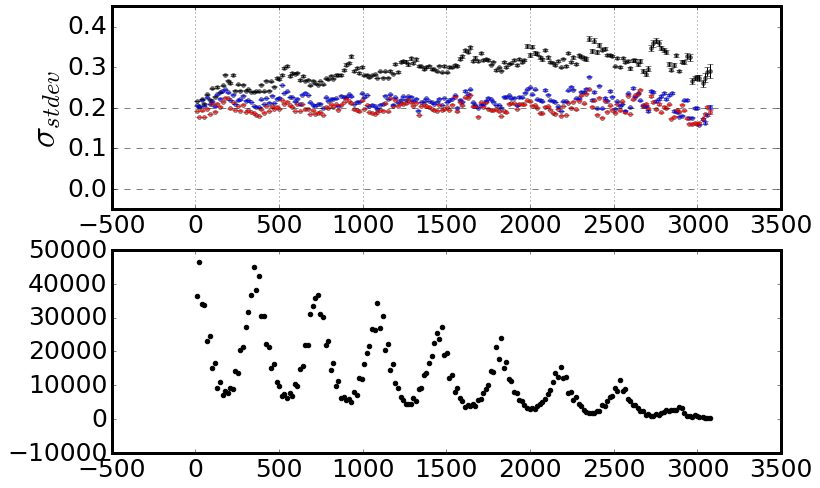

In [14]:
# Plot only sigmaG  and number of counts .... 

### Take data from the peak and the minimum around 1000 days  (log(t) = 3) .  
# First show the zoom - in , to discern where to zoom ... 

%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 14 # 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# x limits for ALL PANELS 
x_left = 0.7
x_right = 3.6

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,(ax1, ax2) = plt.subplots(2,1, figsize=(12,8))


# Panel 1 
for obj in plot_data.keys() : 
    ax1.scatter(plot_data[obj]['meanTau'], plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax1.errorbar(plot_data[obj]['meanTau'], plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax1.set_ylabel(r'$\sigma_{stdev}$') # ,fontsize=20    
#ax.tick_params( axis='x', which='both',  bottom='off', 
#                top='off', labelbottom='off') 
ax1.set_ylim(bottom=y_bott, top=y_top)
#ax.set_xlim(left=x_left, right=x_right)
ax1.set_yticks([0,0.1,0.2,0.3,0.4])
ax1.set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax1.axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax1.axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax1.axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax1.grid(axis='x')

obj = 'qso'
ax2.scatter(plot_data[obj]['meanTau'], plot_data[obj]['binCount'], c='black')

#ax.axvspan(2.93, 3.0,  color='orange',alpha=0.5)
#ax.axvspan(2.82,2.9, color='green',alpha=0.5)
#ax.axvspan(2.69,2.77, color='magenta', alpha=0.5)
plt.savefig(outDir + 'Fig_2_'+str(Min)+'-'+str(Max)+'_stdev_counts.png')

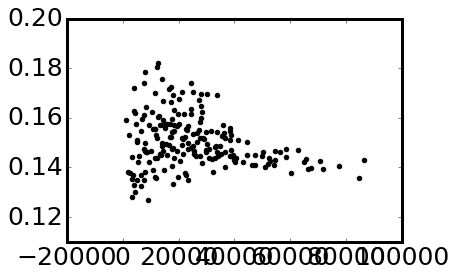

In [22]:
obj = 'starsB'
plt.scatter(plot_data[obj]['binCount'], plot_data[obj]['sigmaG'], c='black')

In [18]:
plot_data['qso'].keys()

dict_keys(['binCount', 'sigmaG', 'muFull', 'stdev', 'muApprox', 'meanTau', 'sigmaFull', 'sigmaApprox'])

In [314]:
# Develop a new way of reading-in the xi, ei , tau..... 

#inDirStars= '../data_products/sf_file_per_LC/stars/'
#File = 'SF_' + good_ids_S_blue[0] +'.txt'
#address = inDirStars+File
#masterFiles_S = os.listdir(inDirStars) 
#object_data =  np.genfromtxt(inDirStars+File, dtype=str)
#count = len(open(address).readlines())

### Read only detailed QSO master files 

In [251]:
# So the dictionary  out_dic['r_cut']  has xi,ei,tau  for qso, starsR,  starsB , 
# within the magnitude cut 18.5 - 19 
# I need to extract from that only those points 
# that have tau  within the two limits marked orange above 

# we also want to combine red and blue stars ...
imp.reload(mod)

# 1)  read in objects in a given mag range 

Min_arr = [ 18,   18.5 ]
Max_arr = [ 18.5, 19   ]

out_dic = {}   # need to initialize the dict beforehand !!! 

mag = 'r'   # which magnitudes to use for cutting and reporting 
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso_detailed/'
        
for i in range(len(Min_arr)):
    
    Min = Min_arr[i]
    Max = Max_arr[i]

    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))

    good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                           cut_mag=mag)

    # 2) for these objects,  read in the xi, ei, tau  points ...   
    # read only qso...
    out_dic[Min]= mod.faster_read_xi_ei(inDirSF = inDirQSO, good_ids=good_ids_QSO, detailed=True)



Using now only lightcurves with SDSS  18.000000< r < 18.500000

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 333

Reading in tau,xi,ei  for 333 objects
[######### ] 99.10%
Finished reading all master files for the selected objects ...

Using now only lightcurves with SDSS  18.500000< r < 19.000000

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 747

Reading in tau,xi,ei  for 747 objects
[######### ] 99.73%
Finished reading all master files for the selected objects ...


### Read only detailed stars master files 

In [232]:
# So the dictionary  out_dic['r_cut']  has xi,ei,tau  for qso, starsR,  starsB , 
# within the magnitude cut 18.5 - 19 
# I need to extract from that only those points 
# that have tau  within the two limits marked orange above 

# we also want to combine red and blue stars ...
imp.reload(mod)

# 1)  read in objects in a given mag range 

Min_arr = [ 18,   18.5 ]
Max_arr = [ 18.5, 19   ]

out_dic = {}   # need to initialize the dict beforehand !!! 

mag = 'r'   # which magnitudes to use for cutting and reporting 
inDirStars   = '../data_products/sf_file_per_LC/stars_detailed/'
inDirQSO = '../data_products/sf_file_per_LC/qso_detailed/'
        
for i in range(len(Min_arr)):
    
    Min = Min_arr[i]
    Max = Max_arr[i]

    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))
    
    # read only stars ...
    good_ids_stars = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                          gi_Max=3, cut_mag=mag + '_mMed')

    # call these stars blue for the purpose of this routine, but it really doesn't matter ..
    out_dic[Min]= mod.faster_read_xi_ei(inDirSF =inDirStars,  good_ids = good_ids_stars, detailed=True)




Using now only lightcurves with SDSS  18.000000< r < 18.500000

Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 3487

Reading in tau,xi,ei for  starsB
[######### ] 99.94%
Finished reading all master files for the selected objects ...

Using now only lightcurves with SDSS  18.500000< r < 19.000000

Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 3825

Reading in tau,xi,ei for  starsB
[##########] 100.00%
Finished reading all master files for the selected objects ...


In [117]:
# Save the QSO  tau, xi,  ei,   chi  for  given tau ranges,  into  a single file ... 

tau_min_arr = [np.power(10,tau) for tau in [0.1]] #[2.69]] #   [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [3.5]] #[2.77]] #   [2.9, 3.0] ]

Min_arr = [ 18, 18.5]
Max_arr = [ 18.5, 19]

for j in range(len(Min_arr)):
#j=0
    Min = Min_arr[j]
    Max = Max_arr[j] 

    print('\nUsing magnitude range   %.2f < mag < %.2f' %(Min,Max))
    for k in range(len(tau_max_arr)): 
        #k=0        
        tau_min = tau_min_arr[k]
        tau_max = tau_max_arr[k]

        print('\n Saving data for   %.3f < tau < %.3f [days]'% (tau_min, tau_max))
        mask_in = (tau_min < out_dic[Min]['qso'][1]) * (out_dic[Min]['qso'][1] < tau_max)

        xi  = out_dic[Min]['qso'][0][mask_in]
        tau = out_dic[Min]['qso'][1][mask_in]
        ei  = out_dic[Min]['qso'][2][mask_in]
        t1  = out_dic[Min]['qso'][3][mask_in]
        t2  = out_dic[Min]['qso'][4][mask_in]
        m1  = out_dic[Min]['qso'][5][mask_in]
        m2  = out_dic[Min]['qso'][6][mask_in]
        e1  = out_dic[Min]['qso'][7][mask_in]
        e2  = out_dic[Min]['qso'][8][mask_in]
        
        
        data = np.column_stack((tau,xi,ei, t1,t2,m1,m2,e1,e2))
        np.savetxt(outDir + 'detail_QSO_'+str(Min)+'-'+str(Max)+'_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days.txt',  
                   data,  header=' tau [days] |     xi [mag] |     ei  [mag] | t1 | t2 | m1 | m2 | e1 | e2 ')


Using magnitude range   18.00 < mag < 18.50

 Saving data for   1.259 < tau < 3162.278 [days]

Using magnitude range   18.50 < mag < 19.00

 Saving data for   1.259 < tau < 3162.278 [days]


In [233]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)




Today we will save our Fig_2 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-10/


In [211]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (500,-1))

from scipy.stats import binned_statistic_2d

### Plot the 'corner' plots 

Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-10/QSO_18.5-19.0_t1_vs_t2_tau_1.258-3162._days_count.png
Saved as /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-04-10/QSO_18.5-19.0_t1_vs_t2_tau_1.258-3162._days_sigmaG.png


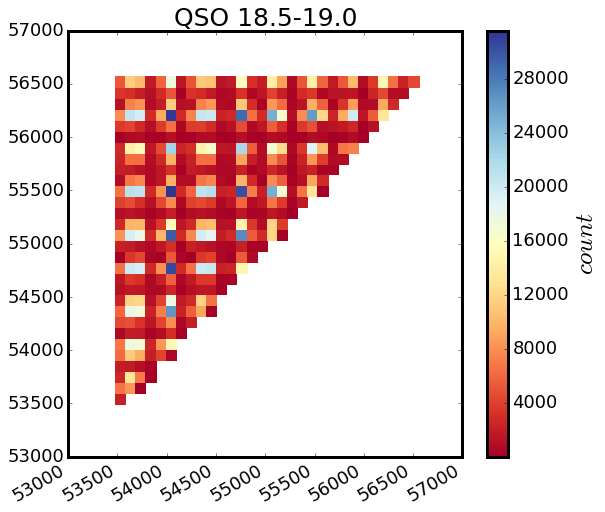

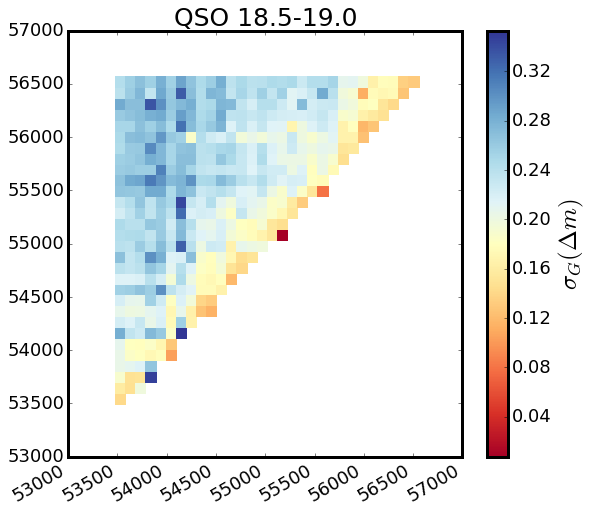

In [255]:
# Plot the t1 vs t2... 

pre = 'QSO' # 'Stars' # 'QSO'
Min =  18.5
Max = Min + 0.5 
#tau_min_arr = [np.power(10,tau) for tau in [2.69,2.82, 2.93]]
#tau_max_arr = [np.power(10,tau) for tau in [2.77, 2.9, 3.0 ]]

# select all points ... 
tau_min_arr = [np.power(10,tau) for tau in [0.1]]#[2.69]] #    [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [3.5]]


x = np.zeros(0) ; y = np.zeros(0) ;  z = np.zeros(0)

for i in range(len(tau_min_arr)):
    tau_min = tau_min_arr[i]
    tau_max = tau_max_arr[i]

    mask_in = (tau_min < out_dic[Min]['tau']) * (out_dic[Min]['tau'] < tau_max)
    t1  = out_dic[Min]['t1'][mask_in]
    t2  = out_dic[Min]['t2'][mask_in]
    xi  = out_dic[Min]['xi'][mask_in]


    x = np.append(x, t1)
    y = np.append(y, t2)
    z = np.append(z, xi)

def func(num) :
    return 0.7413*(np.percentile(num, 75) - np.percentile(num,25))


# set bin size for both plots .... 
bin_size_days = 100 
nbins = int((max(t1) - min(t1)) / bin_size_days )


# plot 1 :  t1 vs t2 colored by  count 
stats = binned_statistic_2d(x, y, values = z, statistic='count', bins=nbins)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$count$', fontsize=25)


ax.set_title(pre+' '+str(Min)+'-'+str(Min+0.5), fontsize=25)
title = pre+'_'+str(Min)+'-'+str(Max)+'_t1_vs_t2_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days_count.png'
plt.savefig(outDir + title, bbox_inches='tight')
print('Saved as %s'%(outDir+title))


# plot 2 :  t1 vs t2 colored by  sigmaG(xi) per bin 

stats = binned_statistic_2d(x, y, values = z, statistic=func, bins=nbins)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label(r'$\sigma_{G}(\Delta m)$', fontsize=25)

ax.set_title(pre+' '+ str(Min)+'-'+str(Min+0.5), fontsize=25)
title = pre+'_'+str(Min)+'-'+str(Max)+'_t1_vs_t2_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days_sigmaG.png'
plt.savefig(outDir + title, bbox_inches='tight')
print('Saved as %s'%(outDir+title))


### Given x,y,z : scatter plot x vs y and color by z  

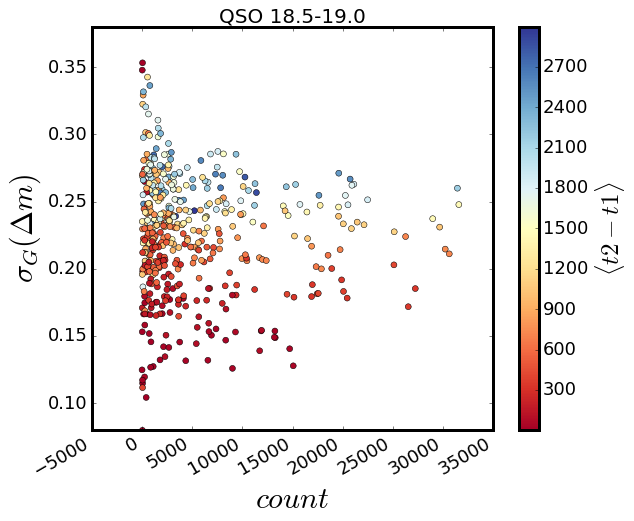

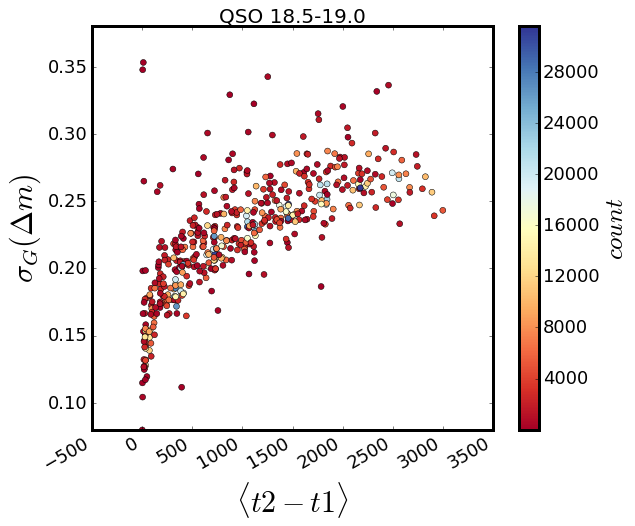

In [258]:
# Grab x,y  pixel values when evaluating  sigmaG(z) per pixel,  and  count(x) per pixel  

# Plot the t1 vs t2... 
Min =  18.5
Max = Min + 0.5 
pre = 'QSO' # 'Stars'  

yMin, yMax = 0.08, 0.38


#tau_min_arr = [np.power(10,tau) for tau in [2.69,2.82, 2.93]]
#tau_max_arr = [np.power(10,tau) for tau in [2.77, 2.9, 3.0 ]]


# select all points ... 
tau_min_arr = [np.power(10,tau) for tau in [0.1]]#[2.69]] #    [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [3.5]]


x = np.zeros(0) ; y = np.zeros(0) ;  z = np.zeros(0)


# loop over selected tau range if needed to patch them together ... 
for i in range(len(tau_min_arr)):
    tau_min = tau_min_arr[i]
    tau_max = tau_max_arr[i]

    mask_in = (tau_min < out_dic[Min]['tau']) * (out_dic[Min]['tau'] < tau_max)
    t1  = out_dic[Min]['t1'][mask_in]
    t2  = out_dic[Min]['t2'][mask_in]
    xi  = out_dic[Min]['xi'][mask_in]

    x = np.append(x, t1)
    y = np.append(y, t2)
    z = np.append(z, xi)

def sigmaG(num) :
    ''' A quick function to calculate sigmaG'''
    return 0.7413*(np.percentile(num, 75) - np.percentile(num,25))


# Calculate  2D statistics on  t2-t1 bins ... 
bin_size_days = 100 
nbins = int((max(t1) - min(t1)) / bin_size_days )  

stats = binned_statistic_2d(x, y, values = z, statistic=sigmaG, bins=nbins)
z_sigmaG, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigmaG = z_sigmaG.flatten()

stats = binned_statistic_2d(x, y, values = z, statistic='count', bins=nbins)
z_count, x_edges, y_edges = stats[0], stats[1], stats[2]
z_count = z_count.flatten()

z = y-x 
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)
z_t2t1, x_edges, y_edges = stats[0], stats[1], stats[2]
z_t2t1 = z_t2t1.flatten()

# Given three pieces of information per bin : 
# sigmaG(delta_mag) ,   mean(t2-t1)  , count ,
# can plot x vs y, and color by z  

fig,ax = plt.subplots(1,1, figsize=(9,8))
cm = plt.cm.get_cmap('RdYlBu')
sc = ax.scatter(z_count, z_sigmaG, lw=0.5, c =z_t2t1 , s=35, cmap = cm )
cbar = plt.colorbar(sc)
cbar.set_label(r'$\langle t2-t1 \rangle$', fontsize=25)



fig.autofmt_xdate()
ax.set_title( pre+ ' '+str(Min)+'-'+str(Min+0.5), fontsize=20)
ax.set_xlabel(r'$count$')
ax.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax.set_ylim(yMin, yMax)
#ax.set_xlim(-100, )
title = pre+'_'+str(Min)+'-'+str(Max)+'sigmaG-count.png'
plt.savefig(outDir +title, bbox_inches = 'tight')
plt.show()


fig,ax = plt.subplots(1,1, figsize=(9,8))
sc = ax.scatter(z_t2t1, z_sigmaG, lw=0.5, c = z_count, s=35, cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label(r'$ count $', fontsize=25)


fig.autofmt_xdate()
ax.set_title(pre+' '+str(Min)+'-'+str(Min+0.5), fontsize=20)
ax.set_xlabel(r'$\langle t2-t1  \rangle $')
ax.set_ylabel(r'$\sigma_{G}(\Delta m)$')
ax.set_ylim(yMin, yMax)
title = pre+'_'+str(Min)+'-'+str(Max)+'sigmaG-t1-t2.png'
plt.savefig(outDir +title, bbox_inches = 'tight')
plt.show()


### Histograms of $\chi$ and $\sigma_{G}$, for quasars and stars in narrow range of $\tau$


Using magnitude range   17.00 < mag < 18.00

Using data for   660.693 < tau < 794.328 [days]

Using data for   851.138 < tau < 1000.000 [days]

Using magnitude range   18.00 < mag < 18.50

Using data for   660.693 < tau < 794.328 [days]

Using data for   851.138 < tau < 1000.000 [days]

Using magnitude range   18.50 < mag < 19.00

Using data for   660.693 < tau < 794.328 [days]

Using data for   851.138 < tau < 1000.000 [days]
saving plot to: /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_2_data/2017-03-24/Fig_3_histogram_panels.png


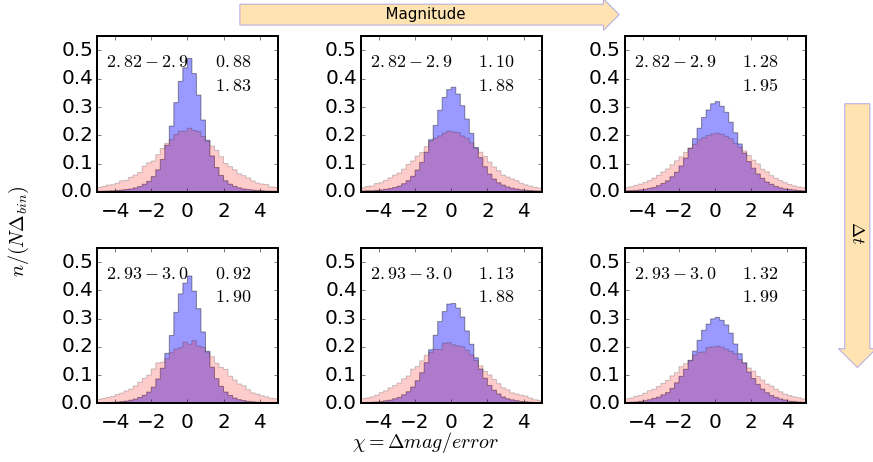

In [277]:
# So we want to lump red and blue stars together ,  and 
# quasars separately... 

#Define function used to plot each histogram in the grid ... 

# Use data from another day : 
#outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_3_data/2016-06-07/')

from matplotlib import rcParams

rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
#rcParams['axes.labelsize'] = 35
axes_label_font = 20 
#rcParams['font.size'] = 25
axes_text_size = 18
rcParams['axes.linewidth'] = 2
rcParams.update({'figure.autolayout': False})

def plot2Chistograms(chiQSO, chiSTAR, Xmin, Xmax, Ymin, Ymax, ax, bins=20, 
                     title='', axes_text_size=25):
    limits = [(Xmin, Xmax, Ymin, Ymax)]
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)        
        
    #plt.tick_params(axis='both', which='major', labelsize=15)
    xTitle = Xmin + 0.05*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    ax.text(xTitle, yTitle, title, fontsize=axes_text_size) # , fontsize=12 

    # plot a histogram
    ax.hist(chiSTAR, bins=bins, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.4)
    ax.hist(chiQSO, bins=bins, normed=True, facecolor='red', histtype='stepfilled', alpha=0.2)

    # plot the robust width of both distributions
    stdev_rob_QSO = 0.7414 *(np.percentile(chiQSO,75) - np.percentile(chiQSO,25) )
    stdev_rob_S = 0.7414 *(np.percentile(chiSTAR,75) - np.percentile(chiSTAR,25) )
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    StarSigmaG = r'$'+str(stdev_rob_S)[:4]+'$'
    ax.text(xTitle, yTitle, StarSigmaG, fontsize=axes_text_size) #  fontsize=12
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.35*(Ymax-Ymin)
    QSOSigmaG = r'$'+str(stdev_rob_QSO)[:4]+'$'
    ax.text(xTitle, yTitle, QSOSigmaG, fontsize=axes_text_size) #  fontsize=12
    
    ax.tick_params(axis='x', pad=10)
    


%matplotlib inline
fig, axs = plt.subplots(2,3, figsize=(12,6))
    
# initiate a storage array for the robust widths of chi distributions ... 
store_fc_starB = np.zeros((3,4))

Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]

tau_min_arr = [np.power(10,tau) for tau in [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [2.9, 3.0] ]

xlims_arr = [5,5]

for j in range(len(Min_arr) ):
    
    Min = Min_arr[j]
    Max = Max_arr[j] 
    print('\nUsing magnitude range   %.2f < mag < %.2f' %(Min,Max))
    for k in range(len(tau_max_arr)): 
        
        tau_min = tau_min_arr[k]
        tau_max = tau_max_arr[k]

        print('\nUsing data for   %.3f < tau < %.3f [days]'% (tau_min, tau_max))
            
        # stars blue 
        mask_in = (tau_min < out_dic[Min]['starsB'][1]) * (out_dic[Min]['starsB'][1] < tau_max)
        xi = out_dic[Min]['starsB'][0][mask_in]
        ei = out_dic[Min]['starsB'][2][mask_in]
        chiS = xi / ei 
        chiSok = chiS[np.abs(chiS)<5]
        
        # calculate the robust width of the chi distribution .... 
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        
        # quasars 
        mask_in = (tau_min < out_dic[Min]['qso'][1]) * (out_dic[Min]['qso'][1] < tau_max)
        xi = out_dic[Min]['qso'][0][mask_in]
        ei = out_dic[Min]['qso'][2][mask_in]
        chiQ = xi / ei 
        chiQok = chiQ[np.abs(chiQ)<xlims_arr[k]]

        # plot histograms
        Xmin = -xlims_arr[k]
        Xmax = xlims_arr[k]
        bins = 40 
        title= r'$ '+' '+ str(np.log10(tau_min))+'-'+str(np.log10(tau_max))+'$'
        row  = k
        col = j 
        plot2Chistograms(chiQok, chiSok, Xmin=Xmin, Xmax=Xmax, Ymin=0.0, 
                             Ymax=0.55, ax=axs[row,col],bins=bins,  
                         title=title, axes_text_size=axes_text_size)
        
        # save the value of robust width of stellar chi distribution...
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        #store_fc_starB[row,column] = [magnitude_max, deltaTrange]
        store_fc_starB[j,k] = stdev_rob_S
        
Xlabel = '$\chi = \Delta mag / error$'
Ylabel = '$n / (N\Delta_{bin})$'
fig.text(0.5, 0.01, Xlabel, ha='center', va='center', fontsize=axes_label_font)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=axes_label_font)


# add two arrows to guide eyes 
bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", ec="b", alpha=0.3, lw=1, clip_on = False)

n_spaces = 30 
t = fig.text(0.5, 1.0, n_spaces*' '+'Magnitude'+n_spaces*' ', ha="center", va="center", rotation=0, size=15, bbox=bbox_props)

n_spaces = 20 
t = fig.text(1.0,0.5 , n_spaces*' '+'$\Delta t$'+n_spaces*' ', ha="center", va="center", rotation=-90, 
             size=18, bbox=bbox_props)




#name = 'poster_r_cut_qso_starsB_histogram_grid.png'
#name = None
name = outDir+'Fig_3_histogram_panels.png'
if (name is None):
    plt.show() 
else:
    print('saving plot to: %s'%name)
    fig.subplots_adjust(wspace=0.46, hspace=0.36, left=0.12, right=0.94, bottom=0.10, top=0.95)
    plt.savefig(name, bbox_inches='tight')
    
plt.savefig(outDir + 'Fig_3_x-Mag_y_tau_chi_histograms.png', bbox_inches = 'tight')

In [47]:
# check that the two are the same ...
Min = 18
Max = 18.5
tau_min = tau_min_arr[0]
tau_max = tau_max_arr[0]

fname1 = outDir + 'QSO_'+str(Min)+'-'+str(Max)+'_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days.txt'
file1 = np.loadtxt(fname1)

fname2  = outDir + 'detail_QSO_'+str(Min)+'-'+str(Max)+'_tau_'+str(tau_min)[:5]+'-'+str(tau_max)[:5]+'_days.txt'
file2 = np.loadtxt(fname2)

x1 = file1[:,1]

x2 = file2[:,1]


Using magnitude range   17.00 < mag < 18.00

Using data for   660.693 < tau < 794.328 [days]


KeyError: 17

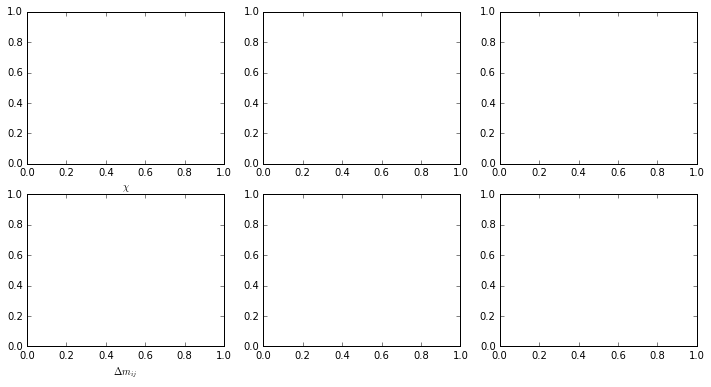

In [23]:
# Make the stellar plot ...

%matplotlib inline
fig, axs = plt.subplots(2,3, figsize=(12,6))
    
Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]

tau_min_arr = [np.power(10,tau) for tau in [2.82, 2.93] ]
tau_max_arr = [np.power(10,tau) for tau in [2.9, 3.0] ]
sample_colors = ['green', 'orange']
alphas = [0.4,0.4]

  # one for chi, the other for sigmaG dist.   

objects = 'stars' # qso' # 'stars'

if objects == 'qso':
    xlims_arr = [10,1]
else : 
    xlims_arr = [5,1]
    
for j in range(len(Min_arr) ):
    
    Min = Min_arr[j]
    Max = Max_arr[j] 
    print('\nUsing magnitude range   %.2f < mag < %.2f' %(Min,Max))
    
    axs[0,j].set_xlabel(r'$\chi$')
    axs[1,j].set_xlabel(r'$\Delta m_{ij}$')
    # plot the two samples (minimum and maximum )
    for k in range(len(tau_max_arr)): 
        
        tau_min = tau_min_arr[k]
        tau_max = tau_max_arr[k]
        hist_color = sample_colors[k]
        print('\nUsing data for   %.3f < tau < %.3f [days]'% (tau_min, tau_max))
        
        if objects == 'stars' : 
            # collect points for this sample :
            # blue stars
            obj = 'starsB'
            mask_in = (tau_min < out_dic[Min][obj][1]) * (out_dic[Min][obj][1] < tau_max)
            xi = out_dic[Min][obj][0][mask_in]
            ei = out_dic[Min][obj][2][mask_in]

            # append red stars
            obj = 'starsR'
            mask_in = (tau_min < out_dic[Min][obj][1]) * (out_dic[Min][obj][1] < tau_max)
            xi = np.append(xi, out_dic[Min][obj][0][mask_in])
            ei = np.append(ei, out_dic[Min][obj][2][mask_in])
            
        if objects == 'qso' : 
            mask_in = (tau_min < out_dic[Min]['qso'][1]) * (out_dic[Min]['qso'][1] < tau_max)
            xi = out_dic[Min]['qso'][0][mask_in]
            ei = out_dic[Min]['qso'][2][mask_in]
        
        chi = xi / ei

        ###########################
        # top row : plot chi distribution 
        ###########################
        row = 0
        col = j
        
        ax = axs[row,col]
        
        Xmin = -xlims_arr[row]
        Xmax = xlims_arr[row]
        
        if objects  == 'qso' : 
            Ymin, Ymax = 0, 0.3
        else:
            Ymin, Ymax = 0, 0.55
            
        axs[row,col].set_xlim(Xmin, Xmax)
        axs[row,col].set_ylim(Ymin, Ymax)  
        
        # define what we are plotting ....
        sample = chi[np.abs(chi)<xlims_arr[row]]
          
        # plot histogram 
        bins=40
        hist = ax.hist(sample, bins=bins, normed=True, facecolor=hist_color, histtype='stepfilled', alpha=alphas[k])
        
        # display the text with  the robust width  of  the  distribution
        stdev_rob = 0.7414 *(np.percentile(sample,75) - np.percentile(sample,25) )
    
        if k == 0 : 
            frac = 0.2
        elif k == 1 : 
            frac = 0.35

        xTitle = Xmin + 0.65*(Xmax-Xmin)
        yTitle = Ymax - frac*(Ymax-Ymin)
        sigmaG = r'$'+str(stdev_rob)[:4]+'$'
        ax.text(xTitle, yTitle, sigmaG, fontsize=axes_text_size, color=hist_color) 
        ax.tick_params(axis='x', pad=5)
        
    
        ###########################
        # bottom row : plot sigmaG distribution 
        ###########################
        row = 1
        col = j
        ax = axs[row,col]
    
        Xmin, Xmax = -xlims_arr[row],xlims_arr[row]
        Ymin, Ymax = 0, 3.2
        axs[row,col].set_xlim(Xmin, Xmax)
        axs[row,col].set_ylim(Ymin, Ymax)  
    
        # define what we are plotting ....
        sample = xi[np.abs(xi)<xlims_arr[row]]
        # plot histogram 
        bins=40
        hist = ax.hist(sample, bins=bins, normed=True, facecolor=hist_color, histtype='stepfilled', alpha=alphas[k])
        
        # display the text with  the robust width  of  the  distribution
        stdev_rob = 0.7414 *(np.percentile(sample,75) - np.percentile(sample,25) )
    
        if k == 0 : 
            frac = 0.2
        elif k == 1 : 
            frac = 0.35

        xTitle = Xmin + 0.65*(Xmax-Xmin)
        yTitle = Ymax - frac*(Ymax-Ymin)
        sigmaG = r'$'+str(stdev_rob)[:4]+'$'
        ax.text(xTitle, yTitle, sigmaG, fontsize=axes_text_size, color=hist_color) 
        
        xTitle = Xmin + 0.05*(Xmax-Xmin)
        yTitle = Ymax - frac*(Ymax-Ymin)
        title = r'$'+str(len(sample))+'$'
        ax.text(xTitle, yTitle, title, fontsize=axes_text_size,color=hist_color) # , fontsize=12 
        
        ax.tick_params(axis='x', pad=5)
fig.subplots_adjust(hspace=0.4)
Ylabel = '$n / (N\Delta_{bin})$'
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=axes_label_font)


# add two arrows to guide eyes 
bbox_props = dict(boxstyle="rarrow,pad=0.2", fc="orange", ec="b", alpha=0.3, lw=1, clip_on = False)

n_spaces = 30 
t = fig.text(0.5, 1.0, n_spaces*' '+'Magnitude'+n_spaces*' ', ha="center", va="center", rotation=0, size=15, bbox=bbox_props)

#plt.legend(handles, ['min', 'max'], bbox_to_anchor=(2, 0),loc = 'lower right')

fig.subplots_adjust(wspace=0.3)
plt.savefig(outDir + 'Fig_3_x-Mag_sigG_chi_histograms_'+objects+'.png', bbox_inches = 'tight')



In [382]:
objects

'qso'